In [1]:
# %%capture
# !pip install statsforecast sktime sweetviz pmdarima keras-tuner xgboost

In [2]:
# Desativar as mensagens de 'warning' que ficam poluindo o output aqui no Colab

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importações dos módulos necessários para autenticar na minha conta Google e acessar o Drive
import  pandas as pd, \
        numpy as np,  \
        requests as rt, \
        seaborn as sns, \
        datetime as dt, \
        matplotlib.pyplot as plt

from IPython.display import display, Markdown

from io               import BytesIO
from matplotlib       import style
from matplotlib.pylab import rcParams
from pandas.plotting  import register_matplotlib_converters

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

from sklearn.metrics        import r2_score, mean_squared_error
from sklearn.ensemble       import GradientBoostingRegressor
from sklearn.linear_model   import LinearRegression
from sklearn.preprocessing  import MinMaxScaler

from sktime.utils.plotting import plot_series
# from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection     import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteScaledError

# Ajustes feitos para geração e criação de gráfico
style.use('ggplot')
rcParams['figure.figsize'] = 15, 6

# Tratar conversões de DateTime entre o Pandas e o Matplotlib
register_matplotlib_converters()

# Symmetric Mean Absolute Percentage Error
smape = MeanAbsolutePercentageError(symmetric=True)

# Mean Absolute Scaled Error -> essa métrica é scaled-free
mase = MeanAbsoluteScaledError()

In [4]:
def sliding_window(data, n_lags=1, n_targets=1, dropnan=True):
	"""
	Rearranja a série temporal como um dataset para aprendizado supervisionado.
	Argumentos:
		data: Sequência de observações. Pode ser list ou NumPy array
		n_lags: Número de lags das observações que serão usadas como input (X).
		n_targets: Número de observações que serão usadas como output (y).
		dropnan: Booleano pra dropar as linhas que ficarem com NaN .
	Retorna:
		Um DataFrame como uma série ajustada para aprendizado supervisionado.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]

	df = pd.DataFrame(data)
	cols, names = list(), list()

	# As lags (t-n, ... t-1)
	for i in range(n_lags, 0, -1):
		cols.append(df.shift(i))
		names += [('X_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# Prever uma sequência (t, t+1, ... t+n)
	for i in range(0, n_targets):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('y_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('y_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# Junta tudo
	agg = pd.concat(cols, axis=1)
	agg.columns = names

	# Dropa as linhas com NaN
	if dropnan:
		agg.dropna(inplace=True)

	return agg # IMPORTANTE!!!! O retorno sai com as colunas com nome zuado. Tem que renomear o DataFrame resultante depois.

In [5]:
# O corte realizado por esse método é simples: pega do início da série até train_size e coloca num dataframe para treino
# O que resta do corte anterior, é colocado no dataframe para teste
def split_train_test(df, train_size=0.7):

  # Tamanho total da série
  size = df.shape[0]

  # Tamanho do treino
  t_size = int(size * train_size)

  train_data = df.iloc[0:t_size]
  validation_data = df.iloc[t_size:]

  return train_data, validation_data

In [6]:
from collections import UserDict

class TimeSeriesTensor(UserDict):
    """A dictionary of tensors for input into the RNN model.

    Use this class to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape
         (samples, time steps, features) for input into Keras

    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """

    def __init__(self, dataset, target, H, tensor_structure, freq='H', drop_incomplete=True):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())

        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)

    def _shift_data(self, H, freq, drop_incomplete):

        # Use the tensor_structures definitions to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()

        idx_tuples = []
        for t in range(1, H+1):
            df['t+'+str(t)] = df[self.target].shift(t*-1, freq=freq)
            idx_tuples.append(('target', 'y', 't+'+str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]

            for col in dataset_cols:

            # do not shift non-sequential 'static' features
                if rng is None:
                    df['context_'+col] = df[col]
                    idx_tuples.append((name, col, 'static'))

                else:
                    for t in rng:
                        sign = '+' if t > 0 else ''
                        shift = str(t) if t != 0 else ''
                        period = 't'+sign+shift
                        shifted_col = name+'_'+col+'_'+period
                        df[shifted_col] = df[col].shift(t*-1, freq=freq)
                        idx_tuples.append((name, col, period))

        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how='any')

        return df

    def _df2tensors(self, dataframe):

        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']

        inputs = {}
        y = dataframe['target']
        y = y.values
        inputs['target'] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].values
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs

    def subset_data(self, new_dataframe):

        # Use this function to recreate the input tensors if the shifted dataframe
        # has been filtered.

        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [7]:
def create_evaluation_df(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, H+1)])
    eval_df['timestamp'] = test_inputs.dataframe.index
    eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
    eval_df['actual'] = np.transpose(test_inputs['target']).ravel()
    eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
    return eval_df

# Carregando os dados de chuva e vazão da estação telemétrica

In [8]:
def read_telemetrica_chuva_vazao(codigoEstacao, tipoEstacao, chave):
  link = 'https://docs.google.com/spreadsheets/d/' + chave + '/export?format=xlsx'
  r = rt.get(link)
  data = r.content
  df = pd.read_excel(BytesIO(data), sheet_name='telemetrica_56994500', header=0, parse_dates=['data_hora'])

  # Ajustando a coluna correspondente à data para o tipo datetime e convertendo para o formato "Period" de frequência "15T" (a cada 15 minutos)
  # A biblioteca 'sktime' só consegue lidar com o campo 'Data' se estiver neste formato de dado
  # df['data_hora'] = pd.DatetimeIndex(df['data_hora']).to_period('15T')

  # A partir do objeto criado anteriormente, agora eu 'corto' entre TREINO e VALIDAÇÃO
  # Será 75% para TESTE e 25% para VALIDAÇÃO calculados à partir do início da série temporal
  # treino, validacao = temporal_train_test_split(df, train_size=0.75, anchor="start")
  # treino.name, validacao.name = 'Treino', 'Validação'

  # ForecastHorizon, o horizonte de tempo que pretende-se realizar a previsão.
  # Está em questão de meses porque os dados são mensais.
  # A ser utilizado com a biblioteca 'sktime'
  # fh = pd.PeriodIndex(data=validacao.index.values)

  # As colunas importantes para entrada no NeuralForecast/LSTM são mesmo "unique_id", "data_hora" e "vazao".
  # Contudo, se colocar mais coluna que conserva relação com o alvo ("vazao"), isso ajuda a aprimorar mais o resultado do modelo. => DICA IMPORTANTE
  # É com isso em mente que entra a coluna "chuva"
  feature_names = ['chuva', 'vazao']
  target_names = 'vazao'

  # O NeuralForecast/LSTM demanda uma coluna nomeada "unique_id"
  # A coluna serve como identificador ÚNICO da série temporal e pode ser qualquer identificador que separe
  # df['unique_id'] = 1

  # Ajustando as colunas "chuva" e "vazao" para tipo numérico
  df.chuva = pd.to_numeric(df.chuva, errors='coerce')
  df.vazao = pd.to_numeric(df.vazao, errors='coerce')

  # Botando o campo "data_hora" pra índice do DataFrame
  df.set_index('data_hora', inplace=True)

  # Agregando os dados por dia e aplicando a média para "vazao" e somatório para "chuva"
  # Além de reduzir o dataset isso também é importante caso tenha muitos dados faltantes (o que é bastante comum)
  df_media_diaria = df.resample('D').agg({'chuva': np.sum, 'vazao': np.mean})

  valid_start_dt = '2023-06-30' # os últimos (90 - 15) dias para validação = 75 dias
  test_start_dt = '2023-09-13' # os últimos 15 dias para testar

  dataset =  {
    'task'              : 'Análise de Série Temporal de estação telemétrica',
    'name'              : str('Dados telemétricos - estação %s' % codigoEstacao),
    'reference'         : "...",
    'feature_names'     : feature_names,
    'target_names'      : target_names,
    'n_samples'         : len(df),
    'n_features'        : len(feature_names),
    'full_serie'        : df,
    'agg_by_day'        : df_media_diaria,
    'valid_start_dt'    : valid_start_dt,
    'test_start_dt'     : test_start_dt,
    'description'       : "Dados de telemetria disponibilizados pela Agência Nacional de Águas e Saneamento Básico do Brasil - ANA",
    'raw_data'          : link,
    'station_code'      : codigoEstacao,
    'station_type'      : tipoEstacao,
    }

  return (dataset)

In [9]:
# Fazendo a carga dos dados a serem analisados
ds = read_telemetrica_chuva_vazao(codigoEstacao='56994500',
                                  tipoEstacao='Telemétrica',
                                  chave="1hl9KK8cmu3DyRaFHwa3E73KdH5nbDhByW-IySNY5oX0")

ds['full_serie']
# ds['full_serie'].resample('D').agg({'chuva': np.sum, 'vazao': np.mean})[ds['agg_by_day'].index >= '2021-06'][['vazao']].plot(xlabel='tempo', ylabel='vazão')

,chuva,vazao
data_hora,,
2023-09-27 09:15:00,0.0,261.4
2023-09-27 09:00:00,0.0,265.9
2023-09-27 08:45:00,0.0,265.9
2023-09-27 08:30:00,0.0,265.9
2023-09-27 08:15:00,0.0,265.9
...,...,...
2015-09-03 10:00:00,NaN,171.3
2015-09-02 20:00:00,NaN,167.5
2015-09-02 10:00:00,NaN,152.4


<Axes: title={'center': 'Chuva por dia (somatório)'}, xlabel='tempo', ylabel='precipitação (mm)'>

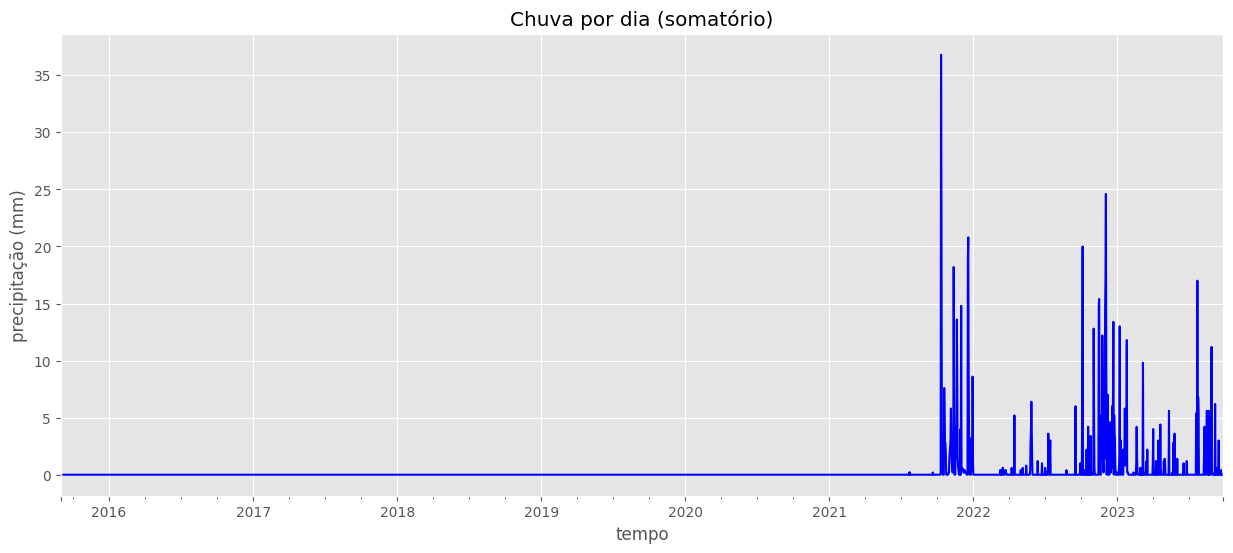

In [10]:
ds['agg_by_day'].chuva.plot(title="Chuva por dia (somatório)", color='b', xlabel='tempo', ylabel='precipitação (mm)')

<Axes: title={'center': 'Vazão por dia (média)'}, xlabel='tempo', ylabel='vazão ($m^3$/s)'>

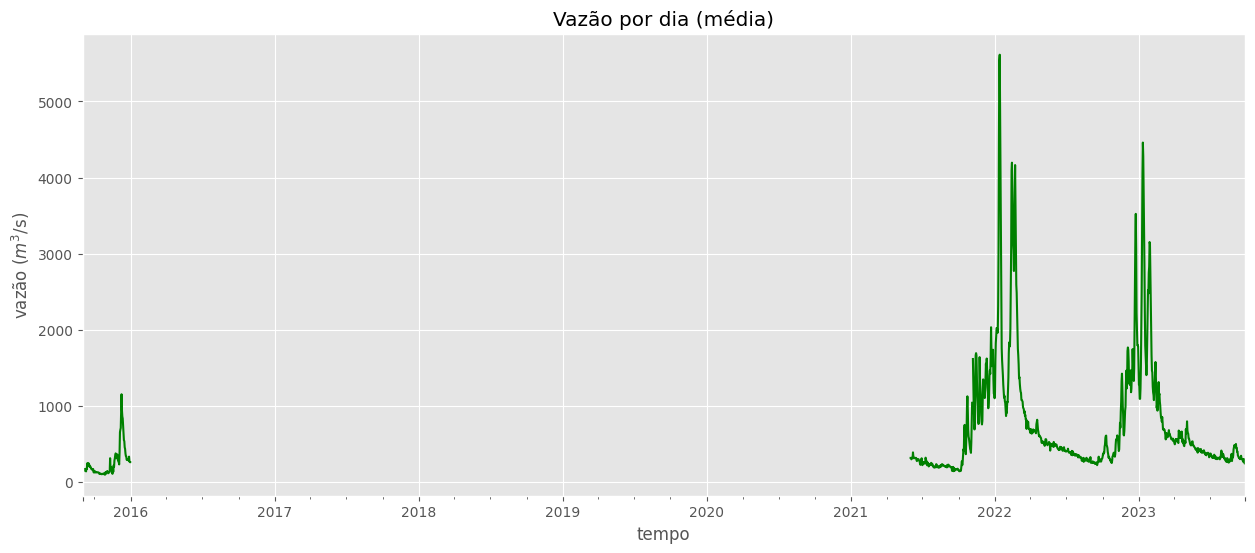

In [11]:
ds['agg_by_day'].vazao.plot(title="Vazão por dia (média)", color='g', xlabel='tempo', ylabel='vazão ($m^3$/s)')

# Pré-processamento dos dados

In [12]:
ds['agg_by_day'].dtypes

chuva    float64
vazao    float64
dtype: object

In [13]:
# Olhando se tem dados faltantes (0 ou NaN) e contando.

ds['agg_by_day'].isna().sum()

chuva       0
vazao    1979
dtype: int64

In [14]:
# Para este dataset, vale à pena mesmo pegar dados a partir de 2021. Tem um salto de anos muito longo, de 2015 para 2021.
# E como para 2015 os dados de chuva estão todos "NaN", seriam excluídos de qualquer forma mesmo.
# Contudo, deixando ".year >= 2021" apenas para compreensão da linha de raciocínio seguida por mim (Welson)

len(ds['agg_by_day'][ds['agg_by_day'].index.year >= 2021]), ds['agg_by_day'][ds['agg_by_day'].index.year >= 2021].isna().sum()

(1000,
 chuva      0
 vazao    152
 dtype: int64)

In [15]:
df_media_diaria_2021 = ds['agg_by_day'][ds['agg_by_day'].index.year >= 2021]
len(df_media_diaria_2021)

1000

In [16]:
# df_media_diaria.dropna(inplace=True)
# df_media_diaria.shape

df_media_diaria_2021.isna().sum()

chuva      0
vazao    152
dtype: int64

In [17]:
df_media_diaria_2021.describe()

,chuva,vazao
count,1000.000000,848.000000
mean,0.768800,772.181046
std,2.824231,782.626901
min,0.000000,142.390000
25%,0.000000,313.491953
50%,0.000000,478.927292
75%,0.000000,959.890964
max,36.800000,5614.181882


In [18]:
#É possível ver que existem dados de vazão NaN. Estes dados serão cortados
df_media_diaria_2021.vazao.fillna(value=df_media_diaria_2021.vazao.mean(), inplace=True)

df_media_diaria_2021.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2021-01-01 to 2023-09-27
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chuva   1000 non-null   float64
 1   vazao   1000 non-null   float64
dtypes: float64(2)
memory usage: 23.4 KB


# Análise exploratória dos dados

In [19]:
# Especificando a frequência como "diária"
# Isso fará surgir, eventualmente, alguma linha com valores "NaN".
df_media_diaria_2021 = df_media_diaria_2021.resample('D').first()

In [20]:
df_media_diaria_2021.describe()

,chuva,vazao
count,1000.000000,1000.000000
mean,0.768800,772.181046
std,2.824231,720.632314
min,0.000000,142.390000
25%,0.000000,326.531198
50%,0.000000,562.079635
75%,0.000000,772.181046
max,36.800000,5614.181882


In [21]:
# Preencher as linhas com "NaN" com a média das vazões e o somatório das chuvas
# Isso já estava praticamente pronto quando da carga do dataset, mas estou deixando especificado aqui para salientar
df_media_diaria_2021['vazao'] = df_media_diaria_2021['vazao'].fillna(df_media_diaria_2021['vazao'].mean())
df_media_diaria_2021['chuva'] = df_media_diaria_2021['chuva'].fillna(df_media_diaria_2021['chuva'].sum())
df_media_diaria_2021

,chuva,vazao
data_hora,,
2021-01-01,0.0,772.181046
2021-01-02,0.0,772.181046
2021-01-03,0.0,772.181046
2021-01-04,0.0,772.181046
2021-01-05,0.0,772.181046
...,...,...
2023-09-23,0.0,283.482604
2023-09-24,0.0,303.319792
2023-09-25,0.0,289.295000


<Axes: title={'center': 'Chuva'}, xlabel='Meses', ylabel='Precipitação (mm)'>

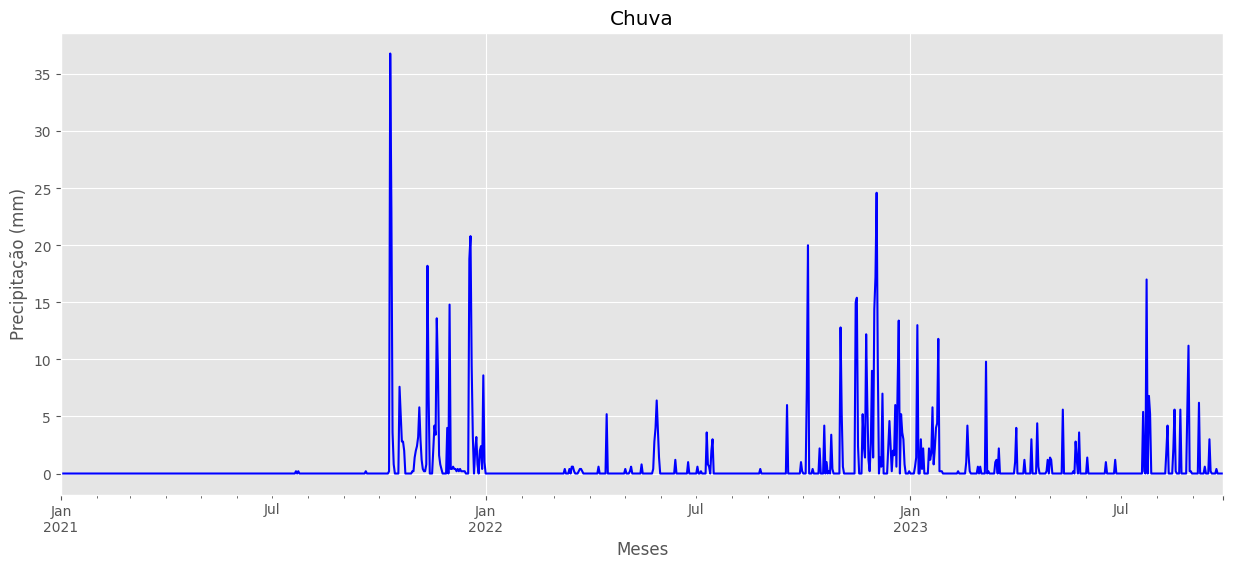

In [22]:
# Plotando a série de chuva
df_media_diaria_2021.chuva.plot(title='Chuva', color='b', xlabel='Meses', ylabel='Precipitação (mm)')

<Axes: title={'center': 'Vazão'}, xlabel='Meses', ylabel='Vazão ($m^3/s$)'>

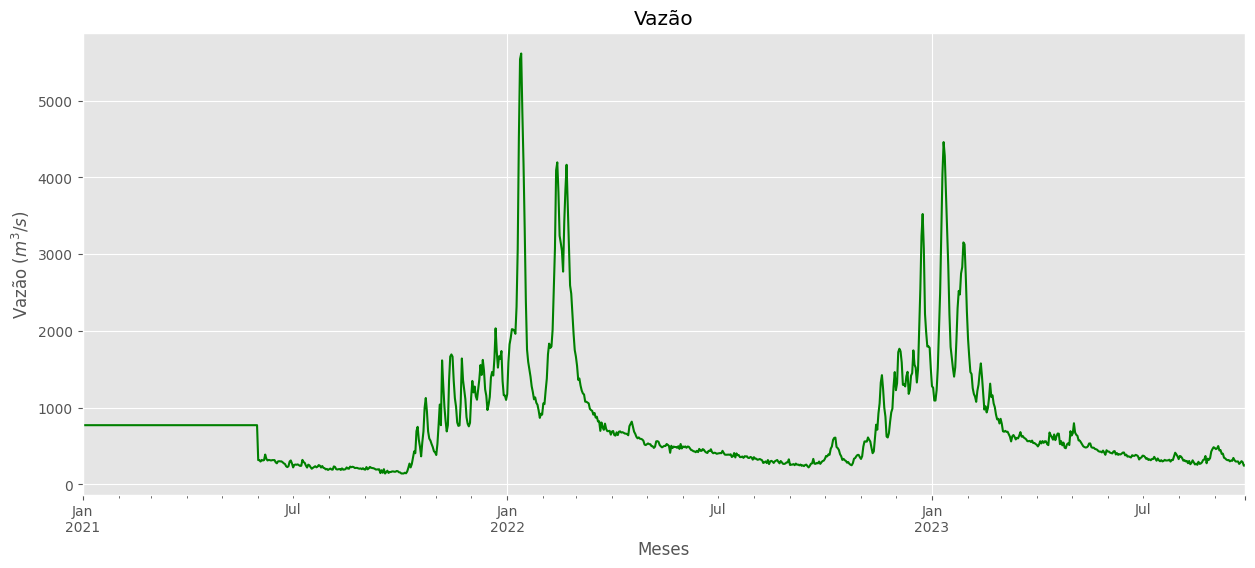

In [23]:
# Plotando a série de vazão
df_media_diaria_2021.vazao.plot(title='Vazão', color='g', xlabel='Meses', ylabel='Vazão ($m^3/s$)')

In [24]:
# Decompondo cada uma das séries analisadas
from statsmodels.tsa.seasonal import seasonal_decompose

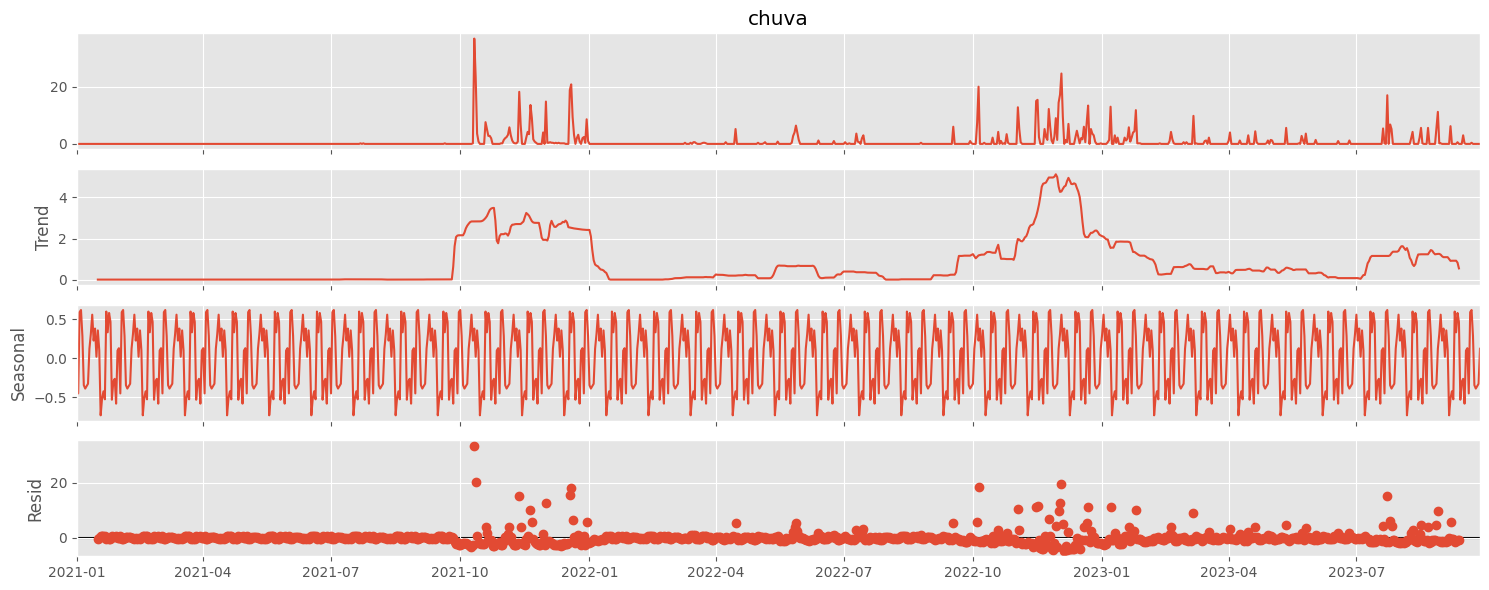

In [25]:
r_chuva = seasonal_decompose(df_media_diaria_2021.chuva, period=30, model="add")
r_chuva.plot();

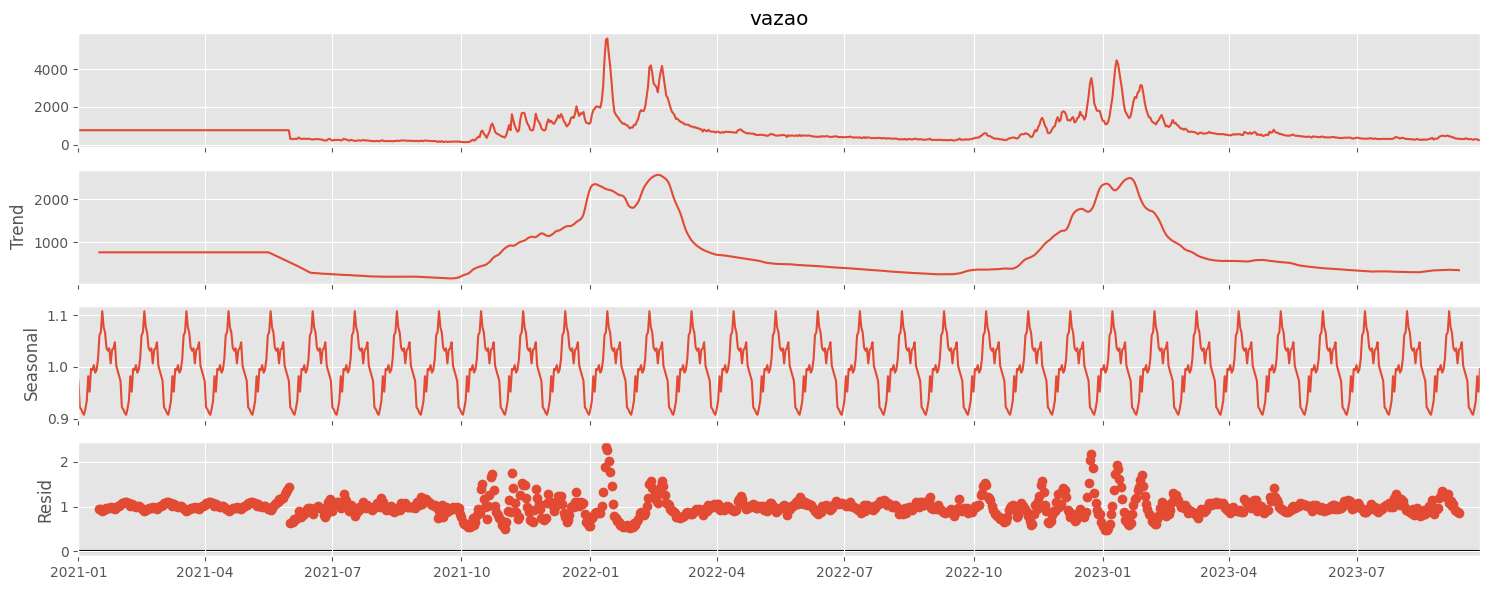

In [26]:
r_vazao = seasonal_decompose(df_media_diaria_2021.vazao, period=30, model="mult")
r_vazao.plot();

### Teste de Estacionariedade

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
result = adfuller(df_media_diaria_2021.vazao)
print(f'p-value: {result[1]}')

p-value: 0.02577700368952791


A série de vazões **é uma série estacionária**.

In [29]:
result = adfuller(df_media_diaria_2021.chuva)
print(f'p-value: {result[1]}')

p-value: 0.00029051329369650755


A série de chuvas **é uma série estacionária**.

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0.5, 1.0, 'ACF "vazao"')

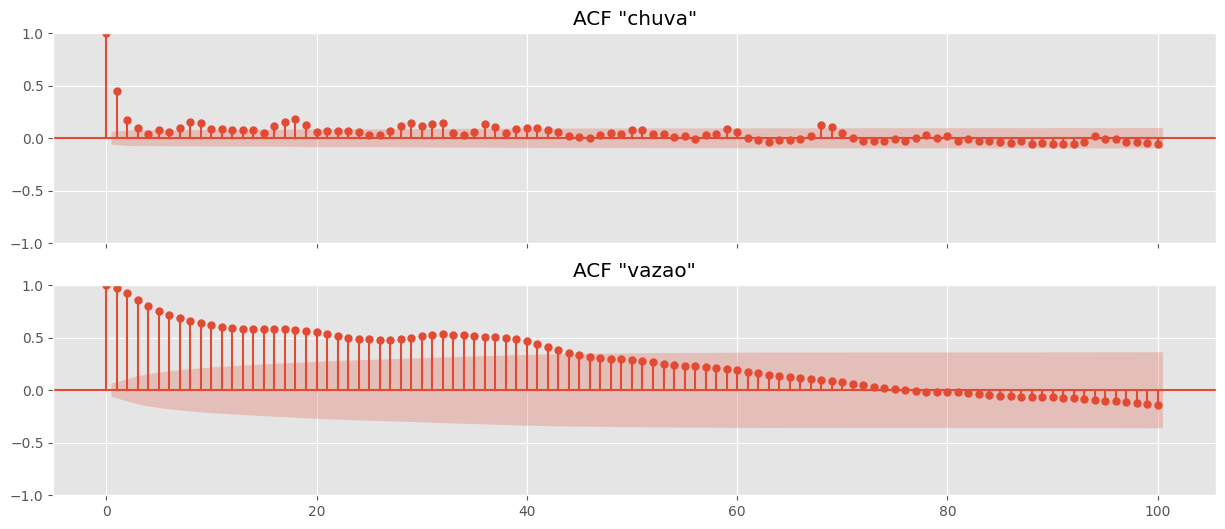

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
plot_acf(df_media_diaria_2021.chuva, ax=axs[0], lags=100, alpha=0.05)
axs[0].set_title('ACF "chuva"')
plot_acf(df_media_diaria_2021.vazao, ax=axs[1], lags=100, alpha=0.05)
axs[1].set_title('ACF "vazao"')

Text(0.5, 1.0, 'PACF "vazao"')

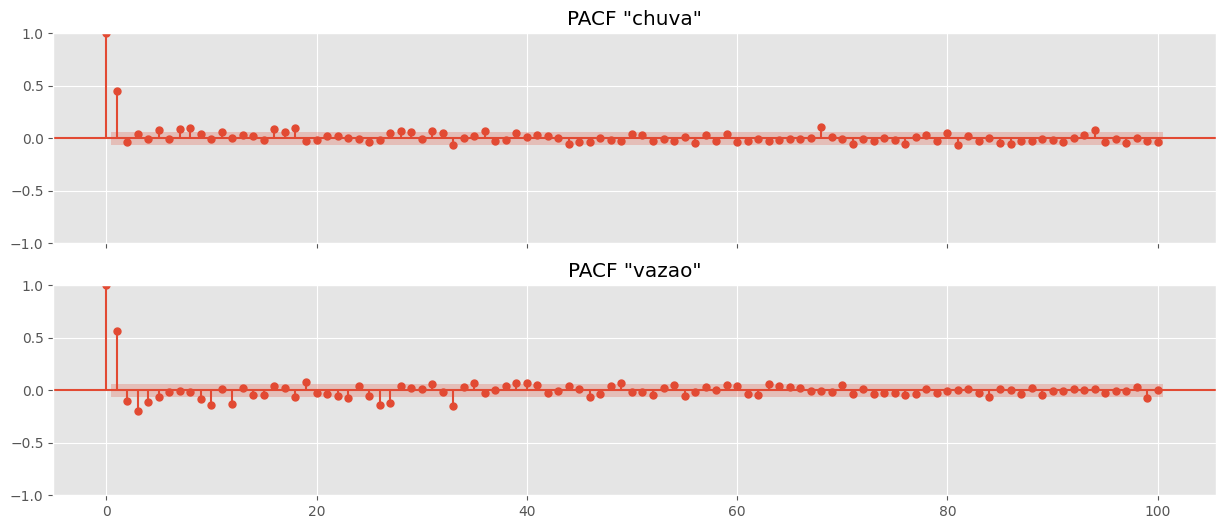

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
plot_pacf(df_media_diaria_2021.chuva, ax=axs[0], lags=100, alpha=0.05)
axs[0].set_title('PACF "chuva"')
plot_pacf(df_media_diaria_2021.vazao.diff(1).dropna(), ax=axs[1], lags=100, alpha=0.05)
axs[1].set_title('PACF "vazao"')

Text(0.5, 0, 'Meses')

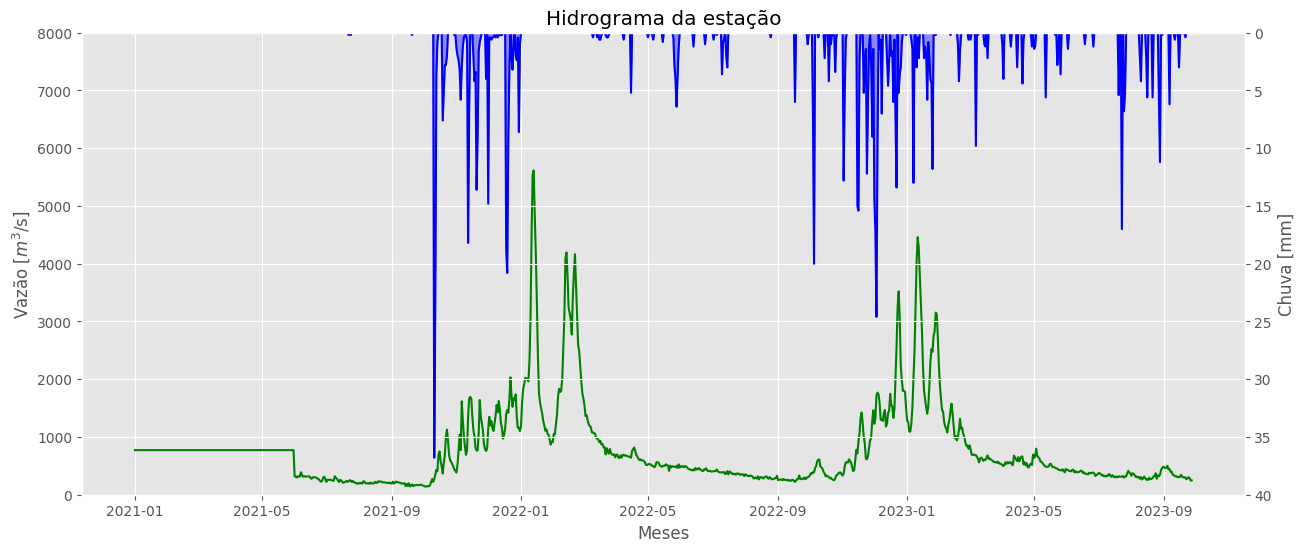

In [33]:
# Hidrograma da estação
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(x=df_media_diaria_2021.index, y="chuva", data=df_media_diaria_2021, color="blue", ax=ax2)
ax2.fill_between(df_media_diaria_2021.index, 0, df_media_diaria_2021["chuva"], color='blue', alpha = 0.4)
ax2.set(ylim=(0, 40))
ax2.set_ylabel("Chuva [mm]")
ax2.invert_yaxis()

sns.lineplot(x=df_media_diaria_2021.index, y="vazao", data=df_media_diaria_2021, color="green", ax=ax1)
ax1.set(ylim=(0, 8000))
ax1.set_title('Hidrograma da estação')
ax1.set_ylabel("Vazão [$m^3$/s]")
ax1.set_xlabel("Meses")

In [34]:
# Precisa equalizar as unidades de medida. Converter m^3 para mm
# Fator de conversão de m^3 para mm^3 -> [mm^3 = m^3 x 1e+9] (1 bilhão)
# df_media_diaria_2021.vazao = df_media_diaria_2021.vazao * 1e+9
# df_media_diaria_2021

In [35]:
# Usando as próprias ferramentas que o Keras disponibiliza para transformar a série temporal no formato que a rede LSTM aceite

T = 7 # usará X lag(s) anterior(es) para criar a matriz em formato para aprendizado supervisionado
HORIZON = 3 # vai prever Y dia(s) à frente
N_FEATURES = 2 # As features são, exatamente, 'chuva' e 'vazão', apenas 2

In [36]:
# Vai pegar dados para TREINAMENTO até a data de 'valid_start_dt' (< '2023-06-30')
train_data = df_media_diaria_2021.copy()[df_media_diaria_2021.index < ds['valid_start_dt']][['chuva', 'vazao']]
train_data

,chuva,vazao
data_hora,,
2021-01-01,0.0,772.181046
2021-01-02,0.0,772.181046
2021-01-03,0.0,772.181046
2021-01-04,0.0,772.181046
2021-01-05,0.0,772.181046
...,...,...
2023-06-25,0.0,385.366042
2023-06-26,1.2,379.785417
2023-06-27,0.0,368.089375


In [37]:
# Normaliza os dados de treino
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(feature_range=(0, 1))
train_data[['chuva', 'vazao']] = X_scaler.fit_transform(train_data)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler.fit(train_data[['vazao']])

MinMaxScaler()

In [38]:
train_data

,chuva,vazao
data_hora,,
2021-01-01,0.000000,0.115098
2021-01-02,0.000000,0.115098
2021-01-03,0.000000,0.115098
2021-01-04,0.000000,0.115098
2021-01-05,0.000000,0.115098
...,...,...
2023-06-25,0.000000,0.044405
2023-06-26,0.032609,0.043385
2023-06-27,0.000000,0.041248


In [39]:
tensor_structure = {'X' : (range(-T+1, 1), ['chuva', 'vazao'])}
tensor_structure

{'X': (range(-6, 1), ['chuva', 'vazao'])}

In [40]:
train_inputs = TimeSeriesTensor(train_data, 'vazao', HORIZON, tensor_structure=tensor_structure, freq='D')
train_inputs.dataframe

tensor        target                             X                           \
feature            y                         chuva                            
time step        t+1       t+2       t+3       t-6       t-5       t-4  t-3   
data_hora                                                                     
2021-01-07  0.115098  0.115098  0.115098  0.000000  0.000000  0.000000  0.0   
2021-01-08  0.115098  0.115098  0.115098  0.000000  0.000000  0.000000  0.0   
2021-01-09  0.115098  0.115098  0.115098  0.000000  0.000000  0.000000  0.0   
2021-01-10  0.115098  0.115098  0.115098  0.000000  0.000000  0.000000  0.0   
2021-01-11  0.115098  0.115098  0.115098  0.000000  0.000000  0.000000  0.0   
...              ...       ...       ...       ...       ...       ...  ...   
2023-06-22  0.042268  0.041973  0.044405  0.000000  0.000000  0.027174  0.0   
2023-06-23  0.041973  0.044405  0.043385  0.000000  0.027174  0.000000  0.0   
2023-06-24  0.044405  0.043385  0.041248  0.027174  0.000000  0.000000  0.0   
2023-06-25  0.043385  0.041248  0.033429  0.000000  0.000000  0.000000  0.0   
2023-06-26  0.041248  0.033429  0.036808  0.000000  0.000000  0.000000  0.0   

tensor                                                                  \
feature                            vazao                                 
time step   t-2  t-1         t       t-6       t-5       t-4       t-3   
data_hora                                                                
2021-01-07  0.0  0.0  0.000000  0.115098  0.115098  0.115098  0.115098   
2021-01-08  0.0  0.0  0.000000  0.115098  0.115098  0.115098  0.115098   
2021-01-09  0.0  0.0  0.000000  0.115098  0.115098  0.115098  0.115098   
2021-01-10  0.0  0.0  0.000000  0.115098  0.115098  0.115098  0.115098   
2021-01-11  0.0  0.0  0.000000  0.115098  0.115098  0.115098  0.115098   
...         ...  ...       ...       ...       ...       ...       ...   
2023-06-22  0.0  0.0  0.000000  0.043204  0.044929  0.040234  0.040885   
2023-06-23  0.0  0.0  0.000000  0.044929  0.040234  0.040885  0.039452   
2023-06-24  0.0  0.0  0.000000  0.040234  0.040885  0.039452  0.038218   
2023-06-25  0.0  0.0  0.000000  0.040885  0.039452  0.038218  0.043519   
2023-06-26  0.0  0.0  0.032609  0.039452  0.038218  0.043519  0.042268   

tensor                                    
feature                                   
time step        t-2       t-1         t  
data_hora                                 
2021-01-07  0.115098  0.115098  0.115098  
2021-01-08  0.115098  0.115098  0.115098  
2021-01-09  0.115098  0.115098  0.115098  
2021-01-10  0.115098  0.115098  0.115098  
2021-01-11  0.115098  0.115098  0.115098  
...              ...       ...       ...  
2023-06-22  0.039452  0.038218  0.043519  
2023-06-23  0.038218  0.043519  0.042268  
2023-06-24  0.043519  0.042268  0.041973  
2023-06-25  0.042268  0.041973  0.044405  
2023-06-26  0.041973  0.044405  0.043385  

[901 rows x 17 columns]

In [41]:
look_back_dt = dt.datetime.strptime(ds['valid_start_dt'], '%Y-%m-%d') - dt.timedelta(days=0) #(days=T-1)

valid_data = df_media_diaria_2021.copy()[(df_media_diaria_2021.index >= look_back_dt) & (df_media_diaria_2021.index < ds['test_start_dt'])][['chuva', 'vazao']]
valid_data[['chuva', 'vazao']] = X_scaler.transform(valid_data)

valid_inputs = TimeSeriesTensor(valid_data, 'vazao', HORIZON, tensor_structure=tensor_structure, freq='D')
valid_inputs.dataframe

tensor        target                             X                      \
feature            y                         chuva                       
time step        t+1       t+2       t+3       t-6  t-5  t-4       t-3   
data_hora                                                                
2023-07-06  0.033727  0.031620  0.034530  0.000000  0.0  0.0  0.000000   
2023-07-07  0.031620  0.034530  0.034487  0.000000  0.0  0.0  0.000000   
2023-07-08  0.034530  0.034487  0.039678  0.000000  0.0  0.0  0.000000   
2023-07-09  0.034487  0.039678  0.034828  0.000000  0.0  0.0  0.000000   
2023-07-10  0.039678  0.034828  0.030601  0.000000  0.0  0.0  0.000000   
...              ...       ...       ...       ...  ...  ...       ...   
2023-09-05  0.055630  0.046756  0.047213  0.005435  0.0  0.0  0.000000   
2023-09-06  0.046756  0.047213  0.037433  0.000000  0.0  0.0  0.000000   
2023-09-07  0.047213  0.037433  0.036003  0.000000  0.0  0.0  0.000000   
2023-09-08  0.037433  0.036003  0.033112  0.000000  0.0  0.0  0.000000   
2023-09-09  0.036003  0.033112  0.031760  0.000000  0.0  0.0  0.168478   

tensor                                                                  \
feature                                      vazao                       
time step        t-2       t-1         t       t-6       t-5       t-4   
data_hora                                                                
2023-07-06  0.000000  0.000000  0.000000  0.038250  0.042488  0.042159   
2023-07-07  0.000000  0.000000  0.000000  0.042488  0.042159  0.039523   
2023-07-08  0.000000  0.000000  0.000000  0.042159  0.039523  0.035146   
2023-07-09  0.000000  0.000000  0.000000  0.039523  0.035146  0.036075   
2023-07-10  0.000000  0.000000  0.000000  0.035146  0.036075  0.032298   
...              ...       ...       ...       ...       ...       ...   
2023-09-05  0.000000  0.000000  0.000000  0.058038  0.062611  0.060891   
2023-09-06  0.000000  0.000000  0.168478  0.062611  0.060891  0.058195   
2023-09-07  0.000000  0.168478  0.000000  0.060891  0.058195  0.059709   
2023-09-08  0.168478  0.000000  0.000000  0.058195  0.059709  0.065386   
2023-09-09  0.000000  0.000000  0.000000  0.059709  0.065386  0.054954   

tensor                                              
feature                                             
time step        t-3       t-2       t-1         t  
data_hora                                           
2023-07-06  0.039523  0.035146  0.036075  0.032298  
2023-07-07  0.035146  0.036075  0.032298  0.033727  
2023-07-08  0.036075  0.032298  0.033727  0.031620  
2023-07-09  0.032298  0.033727  0.031620  0.034530  
2023-07-10  0.033727  0.031620  0.034530  0.034487  
...              ...       ...       ...       ...  
2023-09-05  0.058195  0.059709  0.065386  0.054954  
2023-09-06  0.059709  0.065386  0.054954  0.055630  
2023-09-07  0.065386  0.054954  0.055630  0.046756  
2023-09-08  0.054954  0.055630  0.046756  0.047213  
2023-09-09  0.055630  0.046756  0.047213  0.037433  

[66 rows x 17 columns]

In [42]:
from keras.layers import RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

In [43]:
LSTM_UNITS = [32, 64, 128, 256]
BATCH_SIZE = [1, 8, 16, 32]
EPOCHS = [50, 100, 150]
ACTIVATORS = ['relu', 'tanh', 'softmax', 'sigmoid']

In [44]:
import itertools
from IPython.display import clear_output

# Para prevenir do overfitting
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

# Variável para computar o modelo com o melhor 'val_loss' (quanto menor o val_loss, melhor o modelo)
v_loss = np.inf

# Inicializando as variáveis de interesse
beste_model = None
model = None
hist = None

for units, batch, epoch, activator in itertools.product(LSTM_UNITS, BATCH_SIZE, EPOCHS, ACTIVATORS):

  # Cria o modelo
  model = Sequential()
  model.add(LSTM(units=units, activation=activator, input_shape=(T, N_FEATURES)))
  model.add(RepeatVector(HORIZON))
  model.add(LSTM(units=units, activation=activator, return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  model.add(Flatten())

  model.compile(optimizer='adam', loss='mse')

  model.summary()

  # Treinamento
  hist = model.fit(train_inputs['X'],
                   train_inputs['target'],
                   batch_size=batch,
                   epochs=epoch,
                   validation_data=(valid_inputs['X'], valid_inputs['target']),
                   callbacks=[earlystop],
                   verbose=1)

  # Avaliação do resultado
  if (hist.history['val_loss'][-1] < v_loss):
    v_loss = hist.history['val_loss'][-1]
    n_units = units
    n_batch = batch
    n_epoch = epoch
    name_activator = activator
    best_model = model

  # Zerando as variáveis e limpando o output
  model = None
  hist = None
  clear_output()

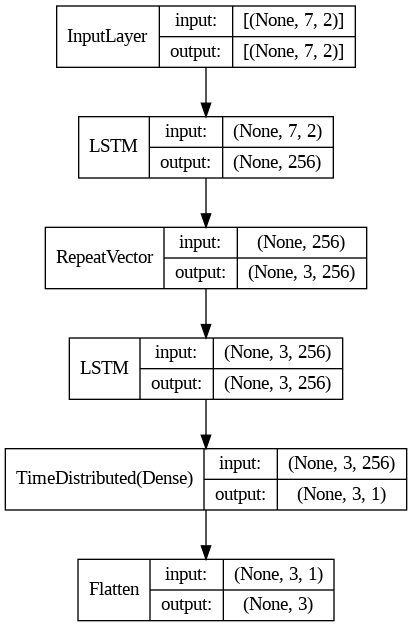

In [45]:
from keras.utils import plot_model
plot_model(best_model, to_file='best_model_plot.png', show_shapes=True, show_layer_names=False)

In [77]:
v_loss, n_units, n_batch, n_epoch, name_activator

(9.864188905339688e-05, 256, 8, 50, 'relu')

In [47]:
model = Sequential()
model.add(LSTM(LSTM_UNITS[2], activation=ACTIVATORS[1], input_shape=(T, N_FEATURES)))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LSTM_UNITS[2], activation=ACTIVATORS[1], return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [48]:
model.compile(optimizer='adam', loss='mse')

In [49]:
model.summary()

Model: "sequential_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_384 (LSTM)             (None, 128)               67072     
                                                                 
 repeat_vector_192 (RepeatV  (None, 3, 128)            0         
 ector)                                                          
                                                                 
 lstm_385 (LSTM)             (None, 3, 128)            131584    
                                                                 
 time_distributed_192 (Time  (None, 3, 1)              129       
 Distributed)                                                    
                                                                 
 flatten_192 (Flatten)       (None, 3)                 0         
                                                                 
Total params: 198785 (776.50 KB)
Trainable params: 1

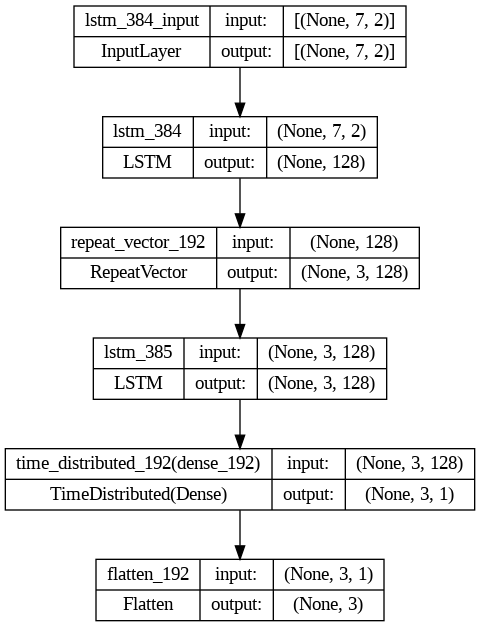

In [50]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [51]:
# Precaver do overfitting
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

In [52]:
history = model.fit(train_inputs['X'],
                    train_inputs['target'],
                    batch_size=BATCH_SIZE[0],
                    epochs=EPOCHS[1],
                    validation_data=(valid_inputs['X'], valid_inputs['target']),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/100
901/901 [==============================] - 14s 12ms/step - loss: 0.0067 - val_loss: 4.0851e-04
Epoch 2/100
901/901 [==============================] - 10s 11ms/step - loss: 0.0036 - val_loss: 3.2407e-04
Epoch 3/100
901/901 [==============================] - 8s 9ms/step - loss: 0.0031 - val_loss: 2.3432e-04
Epoch 4/100
901/901 [==============================] - 9s 10ms/step - loss: 0.0028 - val_loss: 1.8500e-04
Epoch 5/100
901/901 [==============================] - 9s 10ms/step - loss: 0.0026 - val_loss: 2.0033e-04
Epoch 6/100
901/901 [==============================] - 10s 11ms/step - loss: 0.0026 - val_loss: 1.9793e-04
Epoch 7/100
901/901 [==============================] - 9s 10ms/step - loss: 0.0025 - val_loss: 1.1150e-04
Epoch 8/100
901/901 [==============================] - 10s 11ms/step - loss: 0.0024 - val_loss: 8.2226e-04
Epoch 9/100
901/901 [==============================] - 10s 11ms/step - loss: 0.0024 - val_loss: 4.3081e-04
Epoch 10/100
901/901 [====================

In [ ]:
# model.evaluate(valid_inputs['X'], valid_inputs['target'])

print(history.history.keys())
history.history['val_loss'][-1]
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
look_back_dt = dt.datetime.strptime(ds['test_start_dt'], '%Y-%m-%d') - dt.timedelta(days=0) #(days=T-1)

test_data = df_media_diaria_2021.copy()[ds['test_start_dt']:][['chuva', 'vazao']]
test_data[['chuva', 'vazao']] = X_scaler.transform(test_data)

test_inputs = TimeSeriesTensor(test_data, 'vazao', HORIZON, tensor_structure=tensor_structure, freq='D')
test_inputs.dataframe

In [ ]:
predictions = model.predict(test_inputs['X'])
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df['MAPE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']

eval_df, eval_df.groupby('h')['MAPE'].mean()

In [ ]:
# Avaliando o 'best_model'

b_preds = best_model.predict(test_inputs['X'])
b_eval_df = create_evaluation_df(b_preds, test_inputs, HORIZON, y_scaler)
b_eval_df['MAPE'] = (b_eval_df['prediction'] - b_eval_df['actual']).abs() / b_eval_df['actual']

b_eval_df, b_eval_df.groupby('h')['MAPE'].mean()

In [ ]:
plot_df = eval_df[(eval_df.timestamp <= '2023-09-25') & (eval_df.h == 't+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
  plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp <= '2023-09-25') & (eval_df.h == 't+'+str(t))]['prediction'].values

# plot_df

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('data', fontsize=12)
plt.ylabel('vazao', fontsize=12)
plt.show()

In [ ]:
b_plot_df = b_eval_df[(b_eval_df.timestamp <= '2023-09-25') & (b_eval_df.h == 't+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
  b_plot_df['t+'+str(t)] = b_eval_df[(b_eval_df.timestamp <= '2023-09-25') & (b_eval_df.h == 't+'+str(t))]['prediction'].values

# b_plot_df

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(b_plot_df['timestamp'], b_plot_df['actual'], color='red', linewidth=4.0)
# ax.plot(b_plot_df['timestamp'], b_plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(b_plot_df['timestamp'], b_plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
# ax.plot(b_plot_df['timestamp'], b_plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('data', fontsize=12)
plt.ylabel('vazao', fontsize=12)
plt.show()

In [ ]:
# Vou tabular a série temporal pegando 3 lags pra isso.
# Desta forma, considero que os "t-3" dias anteriores medidos influeciam a medição no tempo "t" e também a chuva prevista para o dia "t".
lags = 3 # quantidade de dias observados passado
targets = 1 # prever apenas vazão
tab_data = sliding_window(df_media_diaria_2021.values, n_lags=lags, n_targets=targets)

# Alterando os nomes das colunas para ficar mais legível.
tab_data.columns=['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'vazao']
tab_data

In [ ]:
# Separo em dois DataFrames. DataFrame de input (X) e DataFrame de output (y)
X = tab_data[['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7']]
y = tab_data[['vazao']]

# Resetando os índices e removendo a coluna de índices antiga
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [61]:
# Dividindo os dados entre "treino" e "validação".
X_training, X_validation = split_train_test(X, 0.8)
y_training, y_validation = split_train_test(y, 0.8)

# X_training.shape, X_validation.shape, y_training.shape, y_validation.shape

In [ ]:
# Normalizando os valores pois tem valores EXTREMAMENTE distantes.
scaler = MinMaxScaler(feature_range=(0, 1))

X_training_scaled = scaler.fit_transform(X_training) # Apenas os dados de treinamento passam por fit
X_validation_scaled = scaler.transform(X_validation)

y_training_scaled = scaler.fit_transform(y_training) # Apenas os dados de treinamento passam por fit
y_validation_scaled = scaler.transform(y_validation)

# inverse transform and print
# inversed = scaler.inverse_transform(normalized)
# print(inversed)

# X_training_scaled.shape, X_validation_scaled.shape, y_training_scaled.shape, y_validation_scaled.shape
y_training_scaled.shape

In [ ]:
# Usando o DataFrame tab_data para plotar um heatmap

pd.DataFrame(data=scaler.fit_transform(tab_data), columns=['chuva_4', 'vazao_3', 'chuva_3', 'vazao_2', 'chuva_2', 'vazao_1', 'chuva_1', 'vazao_y']).corr().style.background_gradient(cmap='coolwarm')

In [ ]:
# Usando o sweetviz para avaliar
# import sweetviz as sv
# analyze_report = sv.analyze(tab_data)
# analyze_report.show_html('analyze.html', open_browser=False)

# Apresentando os resultados
# import IPython
# IPython.display.HTML('analyze.html')

Ter separado em intervalo de 3 lags parece uma boa.
As associações percebidas pelo SweetViz mostram que uma chuva num dia 't' influencia menos as chuvas 't+2' e 't+3' dias depois.

# Baseline

Estabelecendo uma baseline para comparar com os modelos LSTM empregados no trabalho

## O modelo Gradient Boosting

In [65]:
m_gb = GradientBoostingRegressor()
m_gb.fit(X_training_scaled, y_training_scaled)

GradientBoostingRegressor()

In [66]:
pred_gb = m_gb.predict(X_validation_scaled)
vazao_pred_gb = pd.DataFrame(data=pred_gb, columns=['pred'])
vazao_pred_gb['obs'] = pd.DataFrame(y_validation_scaled)

(0.11472542779961545, 0.8362514033280629)

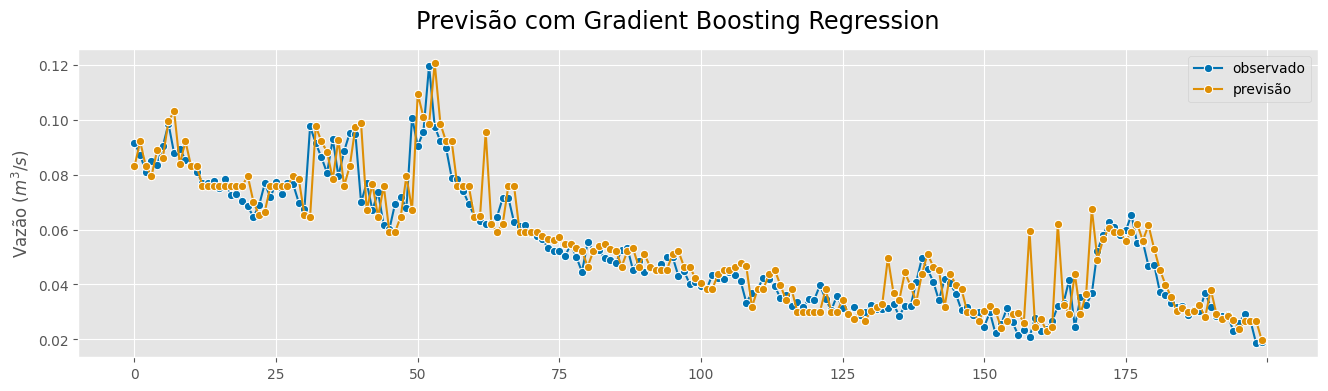

In [67]:
plot_series(vazao_pred_gb['obs'], vazao_pred_gb['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Gradient Boosting Regression')

smape(vazao_pred_gb['obs'].values, vazao_pred_gb['pred'].values),r2_score(vazao_pred_gb['obs'].values, vazao_pred_gb['pred'].values)

## O modelo Linear Regression

In [68]:
m_lr = LinearRegression()
m_lr.fit(X_training_scaled, y_training_scaled)

LinearRegression()

In [69]:
pred_lr = m_lr.predict(X_validation_scaled)
vazao_pred_lr = pd.DataFrame(data=pred_lr, columns=['pred'])
vazao_pred_lr['obs'] = pd.DataFrame(y_validation_scaled)

(0.13441595616969462, 0.8222584796690013)

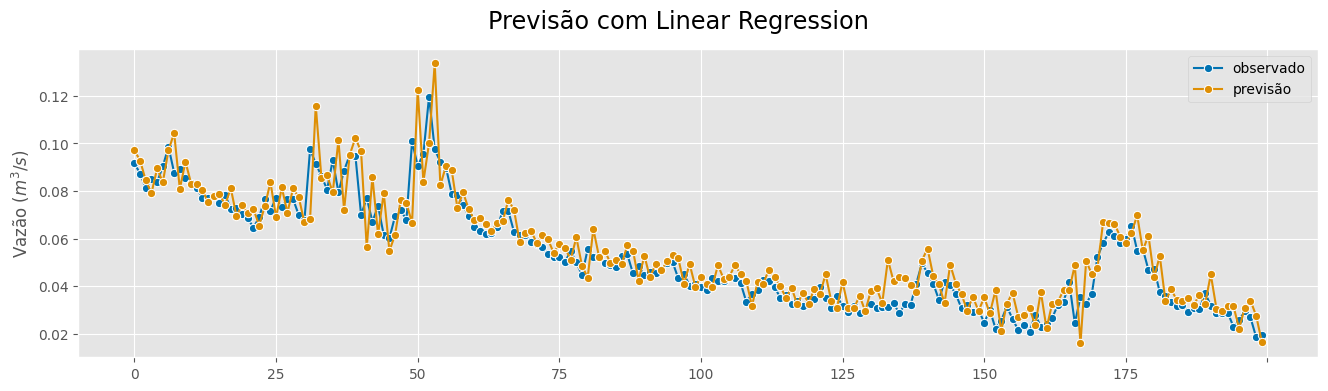

In [70]:
plot_series(vazao_pred_lr['obs'], vazao_pred_lr['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Linear Regression')

smape(vazao_pred_lr['obs'].values, vazao_pred_lr['pred'].values),r2_score(vazao_pred_lr['obs'].values, vazao_pred_lr['pred'].values)

# LSTM

Usando a implementação da biblioteca **KERAS**

In [71]:
# Variável para armazenar todos os cálculos de desempenho dos modelos empregados
desempenho = {}

## Preparando os dados

In [72]:
# X de treino
X_lstm = X_training_scaled.reshape(X_training_scaled.shape[0], X_training_scaled.shape[1], 1)
X_lstm.shape

(797, 7, 1)

In [73]:
# y de treino
y_lstm = y_training_scaled.reshape(y_training_scaled.shape[0], y_training_scaled.shape[1], 1)
y_lstm.shape

(797, 1, 1)

In [74]:
# X para validaçao
X_valid_lstm = X_validation_scaled.reshape(X_validation_scaled.shape[0],  X_validation_scaled.shape[1], 1)
X_valid_lstm.shape

(200, 7, 1)

In [75]:
# y para pevisão
y_valid_lstm = y_validation_scaled.reshape(y_validation_scaled.shape[0],  y_validation_scaled.shape[1], 1)
y_valid_lstm.shape

(200, 1, 1)

## Vanilla LSTM

In [76]:
# vanilla_lstm = Sequential()
# vanilla_lstm.add(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1)))
# vanilla_lstm.add(Dense(1))
# vanilla_lstm.compile(optimizer='adam', loss='mse')

vanilla_lstm = Sequential(name='vanilla_lstm')
vanilla_lstm.add(LSTM(LSTM_UNITS, activation='relu', input_shape=(T, N_FEATURES)))
vanilla_lstm.add(Dense(1))
vanilla_lstm.compile(optimizer='adam', loss='mse')
vanilla_lstm.summary()

TypeError: '<=' not supported between instances of 'list' and 'int'

In [ ]:
vanilla_lstm.fit(train_inputs['X'],
                 train_inputs['target'],
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(valid_inputs['X'], valid_inputs['target']),
                 verbose=0)
vazao_pred_df = pd.DataFrame(data=vanilla_lstm.predict(test_inputs['X'], verbose=1), columns=['pred'])
vazao_pred_df['obs'] = test_inputs['target'].reshape(-1,)
vazao_pred_df

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='y (vazão)',
            title='Vanilla LSTM')

desempenho['VanillaLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values),
                             'R2': r2_score(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values),
                             'MASE' : mase(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values, y_train=train_inputs['target'].reshape(-1,))}

desempenho['VanillaLSTM']

## Seq2Seq LSTM

A característica deste modelo é que ele guarda e passa informações para a célula adiante e retorna para células anteriores informações que foram ajustadas à frente, na rede. Isso potencializa o aprendizado do modelo.

In [ ]:
# bidir_lstm = Sequential()
# bidir_lstm.add(Bidirectional(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1))))
# bidir_lstm.add(Dense(1))
# bidir_lstm.compile(optimizer='adam', loss='mse')

seq2seq_lstm = Sequential(name='seq2seq_lstm')
seq2seq_lstm.add(LSTM(LSTM_UNITS, input_shape=(T, N_FEATURES)))
seq2seq_lstm.add(RepeatVector(HORIZON))
seq2seq_lstm.add(LSTM(LSTM_UNITS, return_sequences=True))
seq2seq_lstm.add(TimeDistributed(Dense(1)))
seq2seq_lstm.add(Flatten())
seq2seq_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# bidir_lstm.build(input_shape=(T, N_FEATURES))
seq2seq_lstm.summary()

In [ ]:
# seq2seq_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
# vazao_pred_df = pd.DataFrame(data=seq2seq_lstm.predict(X_valid_lstm, verbose=0), columns=['pred'])
# vazao_pred_df['obs'] = y_validation_scaled

seq2seq_lstm.fit(train_inputs['X'],
                 train_inputs['target'],
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(valid_inputs['X'], valid_inputs['target']),
                 verbose=0)

vazao_pred_df = pd.DataFrame(data=seq2seq_lstm.predict(test_inputs['X'], verbose=1), columns=['pred'])
vazao_pred_df['obs'] = test_inputs['target']
vazao_pred_df

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Seq2Seq LSTM')

desempenho['Seq2SeqLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values),
                             'R2': r2_score(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values),
                             'MASE' : mase(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values, y_train=train_inputs['target'])}

desempenho['Seq2SeqLSTM']

## Stacked LSTM

A ideia aqui é criar um modelo com mais de uma camada oculta, visando o aprimoramento dos resultados.

In [ ]:
stkd_lstm = Sequential()
stkd_lstm.add(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1)))
stkd_lstm.add(LSTM(128, activation='relu', return_sequences=True))
stkd_lstm.add(Dense(1))
stkd_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
stkd_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
vazao_pred_df = pd.DataFrame(data=stkd_lstm.predict(X_valid_lstm, verbose=0), columns=['pred'])
vazao_pred_df['obs'] = y_validation_scaled

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Stacked LSTM')

desempenho['StackedLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                             'R2': r2_score(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                             'RMSE' : np.sqrt(mean_squared_error(vazao_pred_df['obs'], vazao_pred_df['pred'].values)),
                             'MASE' : mase(vazao_pred_df['obs'], vazao_pred_df['pred'], y_train=y_training_scaled)}

desempenho['StackedLSTM']

## Stacked Bidirectional LSTM

In [ ]:
stkd_bi_lstm = Sequential()
stkd_bi_lstm.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_lstm.shape[1], 1))))
stkd_bi_lstm.add(Bidirectional(LSTM(128, activation='relu')))
stkd_bi_lstm.add(Dense(1))
stkd_bi_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
stkd_bi_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
vazao_pred_df = pd.DataFrame(data=stkd_bi_lstm.predict(X_valid_lstm, verbose=0), columns=['pred'])
vazao_pred_df['obs'] = y_validation_scaled

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Stacked Bidirectional LSTM')

desempenho['StackedBidirectionalLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                                          'R2': r2_score(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                                          'RMSE' : np.sqrt(mean_squared_error(vazao_pred_df['obs'], vazao_pred_df['pred'].values)),
                                          'MASE' : mase(vazao_pred_df['obs'], vazao_pred_df['pred'], y_train=y_training_scaled)}

desempenho['StackedBidirectionalLSTM']

In [ ]:
# Faz o print da qualidade dos resultados de cada método empregado

# for _m1 in desempenho.items():
#   print(_m1[0] + "\n\t" + "MAPE:\t" + str(_m1[1]['MAPE'])
#                + "\n\t" + "R2:\t"   + str(_m1[1]['R2'])
#                + "\n\t" + "MSE:\t"  + str(_m1[1]['MSE']))

# desempenho_df = pd.DataFrame(data=desempenho)
# desempenho_df

### Otimização de hiperparâmetros das redes LSTM

Usando o [KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)

#### Vanilla LSTM

In [ ]:
def build_vanilla(hp):
    model = Sequential()
    model.add(LSTM(# Define the hyperparameter.
                   units = hp.Int("units", min_value=16, max_value=512, step=16),
                   activation = hp.Choice('activation', ["tanh", "relu"])
                   )
    )
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
import keras_tuner

tuner = keras_tuner.RandomSearch(
    hypermodel=build_vanilla,
    executions_per_trial=2,
    objective='val_loss',
    max_trials=10)

tuner.search(X_lstm, y_lstm, epochs=300)

best_model = tuner.get_best_models()[0]

In [ ]:
best_model.build(input_shape=(X_lstm.shape[0], X_lstm.shape[1], 1))
best_model.summary()

In [ ]:
tuner.results_summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
m_opt = build_vanilla(best_hps[0])
m_opt.fit(x=X_lstm, y=y_lstm, epochs=100)

In [ ]:
tuner.results_summary()

In [ ]:
vazao_pred_df = pd.DataFrame(data=m_opt.predict(X_valid_lstm, verbose=0), columns=['pred'])
vazao_pred_df['obs'] = y_validation_scaled

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Vanilla Opt LSTM')

desempenho['VanillaOptLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                                'R2': r2_score(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                                'RMSE' : np.sqrt(mean_squared_error(vazao_pred_df['obs'], vazao_pred_df['pred'].values)),
                                'MASE' : mase(vazao_pred_df['obs'], vazao_pred_df['pred'], y_train=y_training_scaled)}

desempenho['VanillaOptLSTM']

In [ ]:
# Filtrar as colunas do dataframe de desempenho pelo modelo rodado

# Analisando as execuções do modelo Vanilla LSTM
cols = [str('van_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

In [ ]:
desempenho_df[cols].T.plot(title='Vanilla LSTM')

In [ ]:
# Analisando as execuções do modelo Bidirectional LSTM
cols = [str('bidir_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

In [ ]:
desempenho_df[cols].T.plot(title='Bidirectional LSTM')

In [ ]:
# Analisando as execuções do modelo Stacked LSTM
cols = [str('stkd_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

In [ ]:
desempenho_df[cols].T.plot(title='Stacked LSTM')

In [ ]:
# Analisando as execuções do modelo Stacked Bidirectional LSTM
cols = [str('stkd_bi_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

In [ ]:
desempenho_df[cols].T.plot(title='Stacked Bidirectional LSTM')